In [39]:
from time import process_time

from utils import preprocess_data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge,Lasso,ElasticNet,BayesianRidge,ARDRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [33]:
df=pd.read_csv('C:/Users/thefl/Documents/infosys_internship_2024/Git_tracks/GN ML/grocery_sales_prediction/data_alchemy/raw/Train.csv')

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Starting with df as your raw dataframe.
df = df.copy()
Y=df['Item_Outlet_Sales']
# Drop unnecessary columns if present
df.drop(columns=['Item_Identifier', 'Item_Outlet_Sales'], errors='ignore', inplace=True)

# Handle outliers for numeric columns
for column in df.select_dtypes(include='number').columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].apply(
        lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x)
    )

# Fill missing values
df['Item_Weight'] = df.groupby('Item_Type')['Item_Weight'].transform(
    lambda x: x.fillna(x.median())
)
df['Outlet_Size'] = df.groupby('Outlet_Type')['Outlet_Size'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Medium')
)

# Standardize 'Item_Fat_Content'
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(
    {'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'}
)

# Create 'Years_Since_Establishment'
df['Years_Since_Establishment'] = 2024 - df['Outlet_Establishment_Year']

# Create 'Item_Visibility_Bins' with fixed bins and labels
# Here, we assume the max visibility in df to create consistent bins
max_visibility = df['Item_Visibility'].max()
bins = [-0.001, 0.05, 0.15, max_visibility + 0.001]
labels = ['Low', 'Medium', 'High']
df['Item_Visibility_Bins'] = pd.cut(
    df['Item_Visibility'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Since we are not reusing any encoders, let's just drop 'Outlet_Identifier'
# or if we need a mean sales encoding, we can do it directly from df if
# 'Item_Outlet_Sales' was originally present. However, since we're not saving/loading,
# and the user said they don't want to reuse anything, we'll skip mean target encoding.
# If you have the original dataframe (with 'Item_Outlet_Sales'), you can do:
# mean_sales_mapping = original_df.groupby('Outlet_Identifier')['Item_Outlet_Sales'].mean().to_dict()
# global_mean_sales = original_df['Item_Outlet_Sales'].mean()
# df['Outlet_Identifier_Mean_Sales'] = df['Outlet_Identifier'].map(mean_sales_mapping).fillna(global_mean_sales)

# For demonstration, if no mean encoding is needed, just drop 'Outlet_Identifier':
df.drop('Outlet_Identifier', axis=1, inplace=True)

# Encoding
nominal_columns = ['Item_Fat_Content', 'Item_Type', 'Outlet_Type']
ordinal_columns = ['Item_Visibility_Bins', 'Outlet_Size', 'Outlet_Location_Type']

# One-Hot Encoding for nominal columns
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
encoded_nominal = ohe.fit_transform(df[nominal_columns])
encoded_nominal_df = pd.DataFrame(
    encoded_nominal, columns=ohe.get_feature_names_out(nominal_columns)
)
df.reset_index(drop=True, inplace=True)
encoded_nominal_df.reset_index(drop=True, inplace=True)
df = pd.concat([df, encoded_nominal_df], axis=1)
df.drop(nominal_columns, axis=1, inplace=True)

# Ordinal Encoding for ordinal columns
# Fixed categories as per the original code:
ordinal_categories = [
    ['Low', 'Medium', 'High'],    # For Item_Visibility_Bins
    ['Small', 'Medium', 'High'],  # For Outlet_Size
    ['Tier 1', 'Tier 2', 'Tier 3'] # For Outlet_Location_Type
]
ordinal_encoder = OrdinalEncoder(
    categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1
)
df[ordinal_columns] = ordinal_encoder.fit_transform(df[ordinal_columns])

# Log transform 'Item_Visibility'
df['Item_Visibility_Log'] = np.log1p(df['Item_Visibility'])
df.drop('Item_Visibility', axis=1, inplace=True)

# Drop 'Outlet_Establishment_Year' as it's not needed
df.drop('Outlet_Establishment_Year', axis=1, inplace=True)

# Now `df` is preprocessed similarly to what the function did, but inline, with no saving or loading.


In [37]:
x=df
y=Y

In [42]:
models={
    "Random Forest":RandomForestRegressor(),
    "Decision Tree":DecisionTreeRegressor(),
    "Linear Regression":LinearRegression(),
    "SVR":SVR(),
    "KNN":KNeighborsRegressor(),
    "MLP":MLPRegressor(),
    "Ridge":Ridge(),
    "Lasso":Lasso(),
    "ElasticNet":ElasticNet(),
    "BayesianRidge":BayesianRidge(),
    "ARDRegression":ARDRegression(),
    "XGBRegressor":XGBRegressor()
    
}

In [43]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [45]:
for model in models:
    models[model].fit(x_train,y_train)
    y_pred=models[model].predict(x_test)
    # print(f"{model} MSE: {mean_squared_error(y_test,y_pred)}")
    print(f"{model} R2: {r2_score(y_test,y_pred)}")
    

Random Forest R2: 0.5547915991486003
Decision Tree R2: 0.17403570757678444
Linear Regression R2: 0.5778731205228473
SVR R2: 0.19980780723442826
KNN R2: 0.47205106667737495


E:\Anaconda_Files_User\envs\ml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP R2: 0.43641267288622587
Ridge R2: 0.5780766051662762
Lasso R2: 0.5792089599166547
ElasticNet R2: 0.3910568907813565
BayesianRidge R2: 0.5781752121273328
ARDRegression R2: 0.579102037417581
XGBRegressor R2: 0.5218032309855247


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

# Assuming x and y are defined as in your provided code
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# List of models based on their previous performance
models = [
    ("Lasso", Lasso()),
    ("Ridge", Ridge()),
    ("Random Forest", RandomForestRegressor()),
    ("XGBRegressor", XGBRegressor())
]

best_model_name = None
best_score = float('-inf')

for name, model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score = r2_score(y_test, y_pred)
    print(f"{name} R2: {score}")
    if score > best_score:
        best_score = score
        best_model_name = name

print(f"Best Model: {best_model_name} with R2: {best_score}")

Lasso R2: 0.5792089599166547
Ridge R2: 0.5780766051662762
Random Forest R2: 0.5519289772602745
XGBRegressor R2: 0.5218032309855247
Best Model: Lasso with R2: 0.5792089599166547


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Define a simple feedforward neural network
model = Sequential([
    Dense(64, input_dim=x_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(x_train, y_train, epochs=50, batch_size=10, verbose=1)

# Predict and evaluate the model
y_pred = model.predict(x_test)
score = r2_score(y_test, y_pred)

print(f"Deep Learning Model R2: {score}")

E:\Anaconda_Files_User\envs\ml\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Deep Learning Model R2: 0.6054462259363997


Epoch 1/200


E:\Anaconda_Files_User\envs\ml\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5895101.0000 - val_loss: 2059495.0000
Epoch 2/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2050643.6250 - val_loss: 2080402.2500
Epoch 3/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1992700.6250 - val_loss: 2026989.2500
Epoch 4/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2146008.5000 - val_loss: 2026146.0000
Epoch 5/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2062577.0000 - val_loss: 2007183.3750
Epoch 6/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2031384.7500 - val_loss: 1955054.7500
Epoch 7/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1902080.6250 - val_loss: 1948891.6250
Epoch 8/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1919035.6250 - val_loss: 1893581.5000
Epoch 9/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1837162.5000 - val_loss: 1842680.5000
Epoch 10/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1865409.0000 - val_loss: 1803461.1250
Epoch 11/200
171/171 

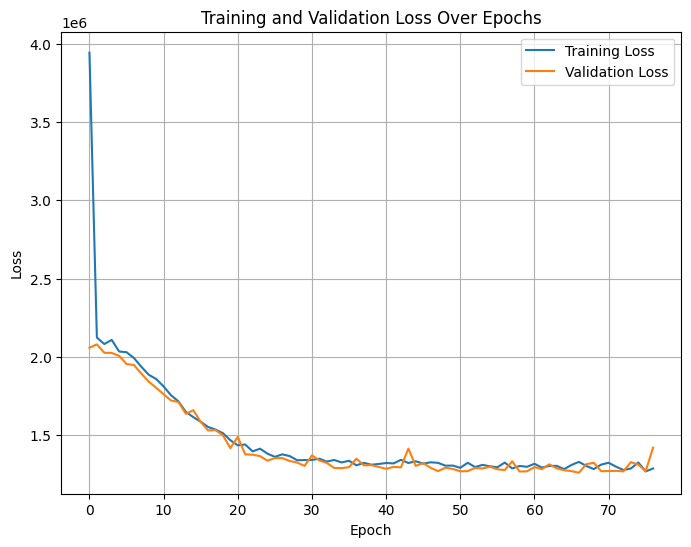

In [52]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Suppose x and y are already defined as your features and target
# Split into train/test
x_train_full, x_test, y_train_full, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Further split train_full into train/validation for model monitoring
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=42)

# Define a more advanced feedforward neural network with dropout and regularization
model = Sequential([
    Dense(128, input_dim=x_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define Early Stopping callback - stop training when val_loss doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with validation data and early stopping
history = model.fit(
    x_train, 
    y_train, 
    epochs=200, 
    batch_size=32, 
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Predict on test set and evaluate
y_pred = model.predict(x_test)
score = r2_score(y_test, y_pred)
print(f"Deep Learning Model R2: {score}")

# Plot training & validation loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [53]:
# Analysis of the model's performance from the plot
# - The training loss decreases steadily with each epoch, indicating that the model is learning well from the training data.
# - The validation loss follows the training loss closely at the start, but starts to diverge slightly towards the end, suggesting potential overfitting.
# - The early stopping mechanism successfully halts the training, preventing unnecessary training and likely overfitting.
# - Overall, the model seems to perform well, with the early stopping callback helping to maintain a balance between underfitting and overfitting.

Epoch 1/100


E:\Anaconda_Files_User\envs\ml\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5469347.0000 - val_loss: 2056699.2500
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2246585.5000 - val_loss: 2053431.0000
Epoch 3/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2037187.5000 - val_loss: 2026474.0000
Epoch 4/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2030822.5000 - val_loss: 2016376.1250
Epoch 5/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2020965.8750 - val_loss: 2002550.2500
Epoch 6/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2075485.8750 - val_loss: 1968540.8750
Epoch 7/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2038282.8750 - val_loss: 1947848.5000
Epoch 8/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2034441.3750 - val_loss: 1929288.8750
Epoch 9/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1858858.2500 - val_loss: 1897460.0000
Epoch 10/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1845875.6250 - val_loss: 1848393.2500
Epoch 11/100
171/171 

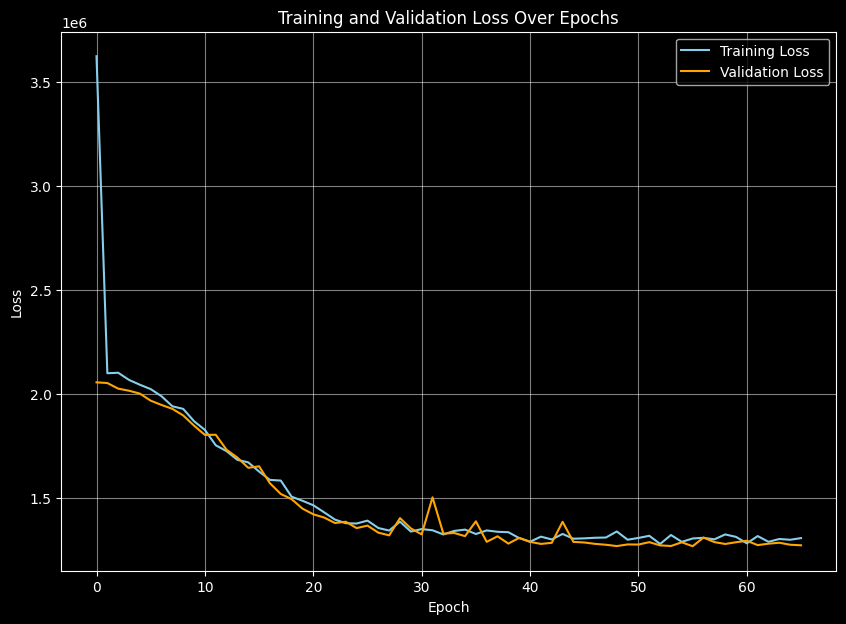

In [54]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

#-------------------------------------
# 1. Prepare train/validation/test sets
#-------------------------------------
# We assume x and y are already defined and preprocessed.
# Example split: 20% test, 20% of the remainder as validation
x_train_full, x_test, y_train_full, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=42)

#-------------------------------------
# 2. Build a more advanced neural network
#    with dropout and L2 regularization
#-------------------------------------
model = Sequential([
    Dense(128, input_shape=(x_train.shape[1],), activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#-------------------------------------
# 3. Early Stopping
#    Stop training if val_loss doesn't improve after 10 epochs
#-------------------------------------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#-------------------------------------
# 4. Train the model with validation data
#-------------------------------------
history = model.fit(
    x_train, 
    y_train, 
    epochs=100,          # Increase epochs; early stopping will prevent overfitting
    batch_size=32,       # Adjust as needed
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

#-------------------------------------
# 5. Evaluate the model on the test set
#-------------------------------------
y_pred = model.predict(x_test)
r2 = r2_score(y_test, y_pred)
print(f"Deep Learning Model R² Score on Test Set: {r2}")

#-------------------------------------
# 6. Plot Training and Validation Loss
#-------------------------------------
plt.style.use('dark_background')
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], label='Training Loss', color='skyblue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()
